<a href="https://colab.research.google.com/github/pablex72/research-camp-time-ser/blob/main/headin_infletion_points_cv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

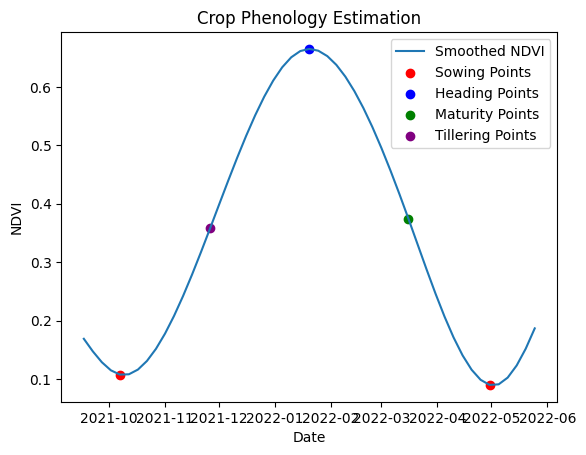

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def crop_phenology_estimation(csv_file, distance_threshold=10):
    # Read data from CSV file
    df = pd.read_csv(csv_file)

    # Parse date and NDVI values
    dates = pd.to_datetime(df['Date'])
    ndvi_values = df['NDVI'].values

    # Apply SG filter to smooth NDVI data
    smoothed_ndvi = ndvi_values

    # Compute first and second order derivatives
    first_derivative = np.gradient(smoothed_ndvi)
    second_derivative = np.gradient(first_derivative)

    # Identify zero crossings in derivatives
    first_derivative_zero_crossings = np.where(np.diff(np.sign(first_derivative)))[0]
    second_derivative_zero_crossings = np.where(np.diff(np.sign(second_derivative)))[0]

    # Initialize lists to store phenology points
    sowing_points = []
    heading_points = []
    maturity_points = []
    tillering_points = []

    # Identify phenology points based on zero crossings
    for each_zero_crossing in first_derivative_zero_crossings:
        if first_derivative[each_zero_crossing] < 0:
            sowing_points.append(each_zero_crossing)
        else:
            heading_points.append(each_zero_crossing)

    for each_zero_crossing in second_derivative_zero_crossings:
        if second_derivative[each_zero_crossing] < 0:
            maturity_points.append(each_zero_crossing)
        else:
            tillering_points.append(each_zero_crossing)

    # Detect and remove anomalous points based on distance thresholds
    anomalous_points = []
    for point_list in [sowing_points, heading_points, maturity_points, tillering_points]:
        for i in range(len(point_list) - 1):
            if point_list[i + 1] - point_list[i] < distance_threshold:
                anomalous_points.append(point_list[i + 1])

    sowing_points = [point for point in sowing_points if point not in anomalous_points]
    heading_points = [point for point in heading_points if point not in anomalous_points]
    maturity_points = [point for point in maturity_points if point not in anomalous_points]
    tillering_points = [point for point in tillering_points if point not in anomalous_points]

    return dates, ndvi_values, sowing_points, heading_points, maturity_points, tillering_points, smoothed_ndvi

# Specify the CSV file path
csv_file_path = '/content/one-season-farm1-infle.csv'

# Run the phenology estimation function
dates, ndvi_values, sowing, heading, maturity, tillering, smoothed_ndvi = crop_phenology_estimation(csv_file_path)

# Plot the smoothed NDVI and identified phenology points
plt.plot(dates, smoothed_ndvi, label='Smoothed NDVI')
plt.scatter(dates[sowing], [smoothed_ndvi[i] for i in sowing], color='red', label='Sowing Points')
plt.scatter(dates[heading], [smoothed_ndvi[i] for i in heading], color='blue', label='Heading Points')
plt.scatter(dates[maturity], [smoothed_ndvi[i] for i in maturity], color='green', label='Maturity Points')
plt.scatter(dates[tillering], [smoothed_ndvi[i] for i in tillering], color='purple', label='Tillering Points')

plt.title('Crop Phenology Estimation')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.legend()
plt.show()
